###### Etude de cas : analyse des fichiers de logs des cyclistes

Objectif: A partir des fichiers contenu dans le dossier ./data/Cyclistes, calculer la durée de chacun des trajets effectués par chaque cycliste.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import udf
from pyspark.sql.window import Window

## 1)  Charger la donnée

Créez une seesion Spark et chargez les données Cyclistes.

In [4]:
spark = SparkSession.builder.getOrCreate()

In [8]:
path = "./data/Cyclistes/*.csv" 
cyclistes = spark.read.format("csv").option("header", "true").load(path, inferSchema=True)

In [9]:
cyclistes.count()

2232000

In [11]:
cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)



In [12]:
cyclistes.show(5)

+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| id|          timestamp|sur_velo| velo|             vitesse|           position|destination_finale|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
| 12|2018-01-01 00:01:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:02:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:03:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:04:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
| 12|2018-01-01 00:05:00|   false|False|0.030000000000000006|(lon:2.07 lat:1.24)|             False|
+---+-------------------+--------+-----+--------------------+-------------------+------------------+
only showing top 5 rows



## 2) Vérifier le nombre de cyclistes

Comptez le nombre d'id uniques.

In [13]:
cyclistes.select("id").distinct().count()

50

## 3) Transformer la colonne timestamp

Lorsqu'on vérifie le type de donnée de la colonne timestamp UNIX, on voit qu'on a une chaîne de caractères. Pour calculer une durée on voudrait transformer en date exploitable en tant que telle.
A l'aide d'une fonction udf, créez une nouvelle colonne date qui contiendra le résultat de la transformation des chaînes de caractères de la colonne timestamp en véritables timestamps.

In [17]:
@udf(returnType = TimestampType())
def transform_timestamp_in_date(date_str):
    from datetime import datetime
    return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")

In [19]:
cyclistes = cyclistes.withColumn("date", transform_timestamp_in_date("timestamp"))

In [20]:
cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- date: timestamp (nullable = true)



## 4) Durée des trajets par id.

1) Trouvez les dates min/max par état de sur_velo, puis par id ET par état de sur_velo.

In [24]:
cyclistes.groupBy(["sur_velo"]).agg(F.min(cyclistes.timestamp), F.max(cyclistes.timestamp)).show()

+--------+-------------------+-------------------+
|sur_velo|     min(timestamp)|     max(timestamp)|
+--------+-------------------+-------------------+
|    true|2018-01-01 01:47:00|2018-01-31 21:32:00|
|   false|2018-01-01 00:01:00|2018-02-01 00:00:00|
+--------+-------------------+-------------------+



In [25]:
cyclistes.sort(["id", "timestamp"]).groupBy(["id", "sur_velo"]).agg(F.min(cyclistes.timestamp), F.max(cyclistes.timestamp)).sort("id").show(5)

+---+--------+-------------------+-------------------+
| id|sur_velo|     min(timestamp)|     max(timestamp)|
+---+--------+-------------------+-------------------+
|  2|   false|2018-01-01 00:01:00|2018-02-01 00:00:00|
|  2|    true|2018-01-01 12:33:00|2018-01-31 20:02:00|
|  3|    true|2018-01-06 06:24:00|2018-01-28 19:33:00|
|  3|   false|2018-01-01 00:01:00|2018-02-01 00:00:00|
|  4|   false|2018-01-01 00:01:00|2018-02-01 00:00:00|
+---+--------+-------------------+-------------------+
only showing top 5 rows



2) Le résultat n'est pas trés pertinent, il faudrait plutôt le début et la fin de chaque trajet par id. Pour cela, il faudrait détecter les changements d'état "sur_vélo".

Créez une fonction python (voir fonction udf) qui permet de detecter ces changements d'état.
Utilisez la classe Window() et la fonction F.lag() avec votre fonction udf pour créer une nouvelle colonne que vous appellerez changement, contenant un 0 si l'état précedent de sur_velo est le même et un 1 si l'état vient de changer pour chaque id.

In [26]:
@udf(returnType = IntegerType())
def changement(etat_actuel, etat_precedent):
    """
    Détecte si les deux états sont différent.
    
    Parametres :
        etat_actuel : valeur sur la ligne courante
                      renvoyée par F.lag (0)
        etat_precedent : valeur sur la ligne précédente
                      renvoyée par F.lag(1)
    Return: 0 s'ils sont égaux, 1 s'il y a une différence
    """
    if etat_precedent == None:
        return 0
    if etat_precedent == etat_actuel:
        return 0
    if etat_actuel != etat_precedent:
        return 1

In [27]:
w = Window.partitionBy("id").orderBy("timestamp")
cyclistes = cyclistes.withColumn("changement", changement( F.lag("sur_velo", 0).over(w), F.lag("sur_velo", 1).over(w)))

In [28]:
cyclistes.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sur_velo: boolean (nullable = true)
 |-- velo: string (nullable = true)
 |-- vitesse: double (nullable = true)
 |-- position: string (nullable = true)
 |-- destination_finale: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- changement: integer (nullable = true)



In [32]:
cyclistes.select("id", "timestamp", "sur_velo", "changement").sort("id", "timestamp").filter((cyclistes.sur_velo == True) & (cyclistes.id != 2)).show(100)

+---+-------------------+--------+----------+
| id|          timestamp|sur_velo|changement|
+---+-------------------+--------+----------+
|  3|2018-01-06 06:24:00|    true|         1|
|  3|2018-01-06 06:25:00|    true|         0|
|  3|2018-01-06 06:26:00|    true|         0|
|  3|2018-01-06 06:27:00|    true|         0|
|  3|2018-01-06 06:28:00|    true|         0|
|  3|2018-01-06 06:29:00|    true|         0|
|  3|2018-01-06 06:30:00|    true|         0|
|  3|2018-01-06 06:31:00|    true|         0|
|  3|2018-01-06 06:32:00|    true|         0|
|  3|2018-01-06 06:33:00|    true|         0|
|  3|2018-01-06 06:34:00|    true|         0|
|  3|2018-01-06 06:35:00|    true|         0|
|  3|2018-01-06 06:36:00|    true|         0|
|  3|2018-01-06 06:37:00|    true|         0|
|  3|2018-01-06 06:38:00|    true|         0|
|  3|2018-01-06 06:39:00|    true|         0|
|  3|2018-01-06 06:40:00|    true|         0|
|  3|2018-01-06 06:41:00|    true|         0|
|  3|2018-01-06 06:42:00|    true|

3) Grâce à cette nouvelle colonne changement, trouvez un moyen qui permettra de numeroter les trajets pour chaque id et stockez les résulats dans une nouvelle colonne appelée numero_de_trajet.

Solution 1 :

In [33]:
@udf(returnType = IntegerType())
def somme(changement, sur_velo):
    global i
    if sur_velo == 0:
        return 0
    elif changement == 1:
        i += 1
    return i

In [34]:
i = 0
cyclistes1 = cyclistes.withColumn("numero_trajet", somme(F.lag("changement", 0).over(w), F.lag("sur_velo", 0).over(w)))

In [35]:
cyclistes1.select("id", "timestamp", "sur_velo", "changement", "numero_trajet").sort("id", "timestamp").filter((cyclistes.sur_velo == True)).show(10)

+---+-------------------+--------+----------+-------------+
| id|          timestamp|sur_velo|changement|numero_trajet|
+---+-------------------+--------+----------+-------------+
|  2|2018-01-01 12:33:00|    true|         1|            1|
|  2|2018-01-01 12:34:00|    true|         0|            1|
|  2|2018-01-01 12:35:00|    true|         0|            1|
|  2|2018-01-01 12:36:00|    true|         0|            1|
|  2|2018-01-01 19:59:00|    true|         1|            2|
|  2|2018-01-01 20:00:00|    true|         0|            2|
|  2|2018-01-02 12:33:00|    true|         1|            3|
|  2|2018-01-02 12:34:00|    true|         0|            3|
|  2|2018-01-02 19:59:00|    true|         1|            4|
|  2|2018-01-02 20:00:00|    true|         0|            4|
+---+-------------------+--------+----------+-------------+
only showing top 10 rows



In [36]:
cyclistes1.select("id", "timestamp", "sur_velo", "changement", "numero_trajet").sort("timestamp").filter(cyclistes.id==26).where(cyclistes.sur_velo==1).show(100)

+---+-------------------+--------+----------+-------------+
| id|          timestamp|sur_velo|changement|numero_trajet|
+---+-------------------+--------+----------+-------------+
| 26|2018-01-01 07:50:00|    true|         1|            1|
| 26|2018-01-01 07:51:00|    true|         0|            1|
| 26|2018-01-01 17:55:00|    true|         1|            2|
| 26|2018-01-01 17:56:00|    true|         0|            2|
| 26|2018-01-02 07:50:00|    true|         1|            3|
| 26|2018-01-02 07:51:00|    true|         0|            3|
| 26|2018-01-02 17:55:00|    true|         1|            4|
| 26|2018-01-02 17:56:00|    true|         0|            4|
| 26|2018-01-04 07:54:00|    true|         1|            5|
| 26|2018-01-04 07:55:00|    true|         0|            5|
| 26|2018-01-04 07:56:00|    true|         0|            5|
| 26|2018-01-04 17:55:00|    true|         1|            6|
| 26|2018-01-04 17:56:00|    true|         0|            6|
| 26|2018-01-05 07:50:00|    true|      

In [38]:
trajets1 = cyclistes1.select("id", "timestamp", "numero_trajet").where(cyclistes.sur_velo==1)

In [39]:
trajets1.select("id", "timestamp", "numero_trajet").orderBy('id', 'timestamp').show(10)

+---+-------------------+-------------+
| id|          timestamp|numero_trajet|
+---+-------------------+-------------+
|  2|2018-01-01 12:33:00|            1|
|  2|2018-01-01 12:34:00|            1|
|  2|2018-01-01 12:35:00|            1|
|  2|2018-01-01 12:36:00|            1|
|  2|2018-01-01 19:59:00|            2|
|  2|2018-01-01 20:00:00|            2|
|  2|2018-01-02 12:33:00|            3|
|  2|2018-01-02 12:34:00|            3|
|  2|2018-01-02 19:59:00|            4|
|  2|2018-01-02 20:00:00|            4|
+---+-------------------+-------------+
only showing top 10 rows



Solution 2 :

In [12]:
windowval = Window.orderBy(["id", "timestamp"]).partitionBy("id")
windowval = windowval.rangeBetween(Window.unboundedPreceding, 0)

In [13]:
cyclistes2 = cyclistes.withColumn("numero_trajet", F.sum("changement").over(windowval))

In [14]:
cyclistes2.select("id", "timestamp", "sur_velo", "changement", "numero_trajet").sort("id", "timestamp").filter((cyclistes.sur_velo == True)).show(10)

+---+-------------------+--------+----------+-------------+
| id|          timestamp|sur_velo|changement|numero_trajet|
+---+-------------------+--------+----------+-------------+
|  2|2018-01-01 12:33:00|    true|         1|            1|
|  2|2018-01-01 12:34:00|    true|         0|            1|
|  2|2018-01-01 12:35:00|    true|         0|            1|
|  2|2018-01-01 12:36:00|    true|         0|            1|
|  2|2018-01-01 19:59:00|    true|         1|            3|
|  2|2018-01-01 20:00:00|    true|         0|            3|
|  2|2018-01-02 12:33:00|    true|         1|            5|
|  2|2018-01-02 12:34:00|    true|         0|            5|
|  2|2018-01-02 19:59:00|    true|         1|            7|
|  2|2018-01-02 20:00:00|    true|         0|            7|
+---+-------------------+--------+----------+-------------+
only showing top 10 rows



In [15]:
cyclistes2.select("id", "timestamp", "sur_velo", "changement", "numero_trajet").sort("timestamp").filter(cyclistes.id==26).where(cyclistes.sur_velo==1).show(10)

+---+-------------------+--------+----------+-------------+
| id|          timestamp|sur_velo|changement|numero_trajet|
+---+-------------------+--------+----------+-------------+
| 26|2018-01-01 07:50:00|    true|         1|            1|
| 26|2018-01-01 07:51:00|    true|         0|            1|
| 26|2018-01-01 17:55:00|    true|         1|            3|
| 26|2018-01-01 17:56:00|    true|         0|            3|
| 26|2018-01-02 07:50:00|    true|         1|            5|
| 26|2018-01-02 07:51:00|    true|         0|            5|
| 26|2018-01-02 17:55:00|    true|         1|            7|
| 26|2018-01-02 17:56:00|    true|         0|            7|
| 26|2018-01-04 07:54:00|    true|         1|            9|
| 26|2018-01-04 07:55:00|    true|         0|            9|
+---+-------------------+--------+----------+-------------+
only showing top 10 rows



In [16]:
trajets2 = cyclistes2.select("id", "timestamp", "numero_trajet").where(cyclistes.sur_velo==1)

4) Il suffit maintenant de repêter la première étape, c'est a dire récupérer le début et la fin de chaque trajet pour chaque id. Puis calculer la durée des trajets. (Pensez à récuperer les "vrai trajet au préalable (avec un état sur_vélo = 1).

In [17]:
trajets = trajets2.groupBy(["id", "numero_trajet"]).agg(F.min(trajets2.timestamp) , F.max(trajets2.timestamp))

In [18]:
duree = trajets.withColumn('Durée', (F.unix_timestamp("max(timestamp)") - F.unix_timestamp('min(timestamp)'))/60)
duree.sort("id", "numero_trajet").show(10)


+---+-------------+-------------------+-------------------+-----+
| id|numero_trajet|     min(timestamp)|     max(timestamp)|Durée|
+---+-------------+-------------------+-------------------+-----+
|  2|            1|2018-01-01 12:33:00|2018-01-01 12:36:00|  3.0|
|  2|            3|2018-01-01 19:59:00|2018-01-01 20:00:00|  1.0|
|  2|            5|2018-01-02 12:33:00|2018-01-02 12:34:00|  1.0|
|  2|            7|2018-01-02 19:59:00|2018-01-02 20:00:00|  1.0|
|  2|            9|2018-01-03 12:33:00|2018-01-03 12:34:00|  1.0|
|  2|           11|2018-01-03 19:59:00|2018-01-03 20:00:00|  1.0|
|  2|           13|2018-01-04 12:33:00|2018-01-04 12:34:00|  1.0|
|  2|           15|2018-01-04 19:59:00|2018-01-04 20:00:00|  1.0|
|  2|           17|2018-01-05 12:33:00|2018-01-05 12:34:00|  1.0|
|  2|           19|2018-01-05 19:59:00|2018-01-05 20:00:00|  1.0|
+---+-------------+-------------------+-------------------+-----+
only showing top 10 rows



In [ ]:
duree.sort("id", "numero_trajet").filter(cyclistes.id==10).show(10)

## 5) Data visualisation

Convertissez votre dataframe pyspark en dataframe pandas.

In [19]:
df_pandas = duree.sort("id", "numero_trajet").toPandas()
df_pandas

,id,numero_trajet,min(timestamp),max(timestamp),Durée
0,2,1,2018-01-01 12:33:00,2018-01-01 12:36:00,3.0
1,2,3,2018-01-01 19:59:00,2018-01-01 20:00:00,1.0
2,2,5,2018-01-02 12:33:00,2018-01-02 12:34:00,1.0
3,2,7,2018-01-02 19:59:00,2018-01-02 20:00:00,1.0
4,2,9,2018-01-03 12:33:00,2018-01-03 12:34:00,1.0
...,...,...,...,...,...
1759,51,59,2018-01-26 16:39:00,2018-01-26 17:31:00,52.0
1760,51,61,2018-01-29 06:29:00,2018-01-29 08:48:00,139.0
1761,51,63,2018-01-29 17:08:00,2018-01-29 18:47:00,99.0
1762,51,65,2018-01-30 06:29:00,2018-01-30 09:45:00,196.0


In [20]:
import pandas as pd
#pd.set_option("display.max_rows", None)
#df_pandas.head(500)

A l'aide des librairies matplotlib et/ou seaborn, réalisez un graphique en barre montrant le temps total passé à vélo par chaque cycliste.

In [21]:
import seaborn as sns
%matplotlib inline

In [22]:
total_bike_time = duree.groupBy("id").agg({"Durée" : "sum"}).sort("id").toPandas()
total_bike_time.head()

,id,sum(Durée)
0,2,83.0
1,3,3657.0
2,4,930.0
3,5,384.0
4,6,1971.0


/tmp/ipykernel_228/2544512364.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="id", y="sum(Durée)", data=total_bike_time, palette="magma")


<Axes: xlabel='id', ylabel='sum(Durée)'>

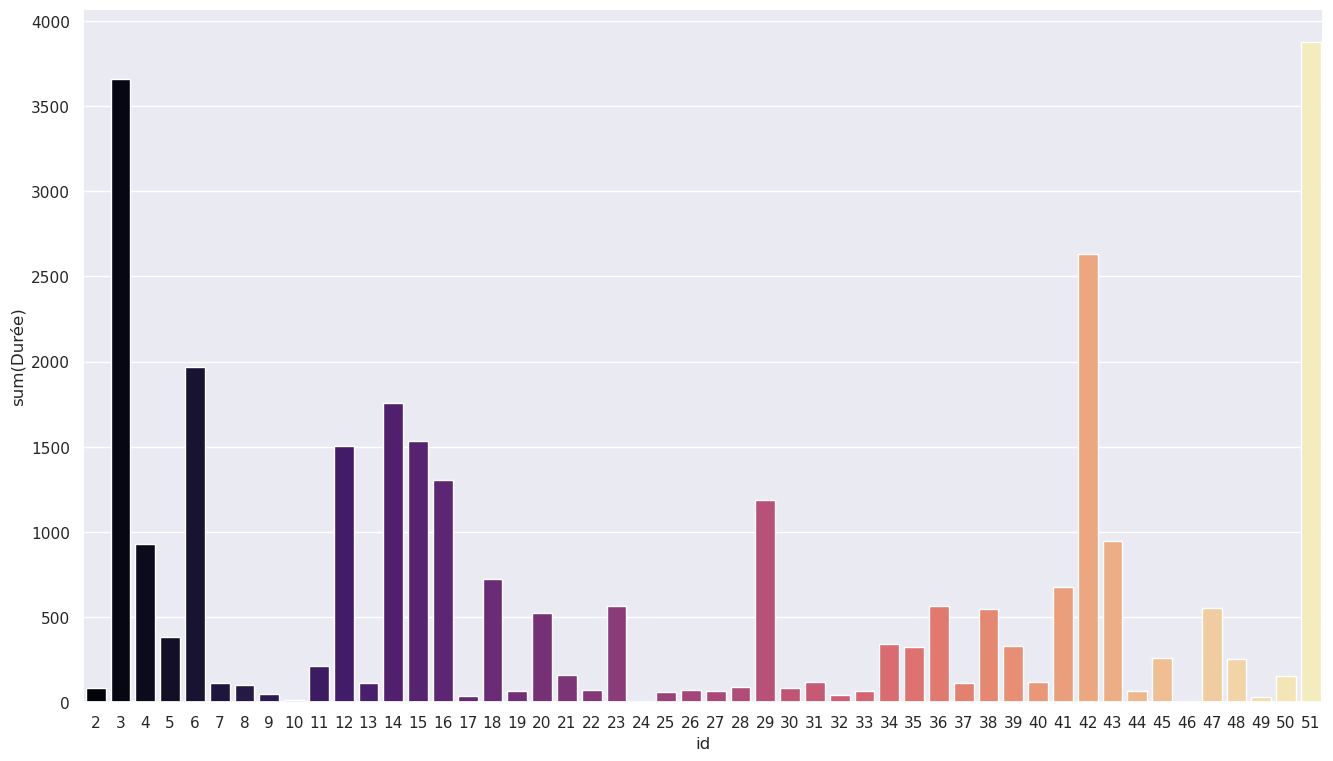

In [23]:
sns.set(rc={'figure.figsize':(16, 9)})
sns.barplot(x="id", y="sum(Durée)", data=total_bike_time, palette="magma")

Réalisez un graphique en barre qui affiche le temps de chaque trajet d'un cycliste. Faites en sorte qu'on puisse choisir un id et afficher les trajets de cet id.

In [24]:
def plotTrajet(ID):
    df = duree.where(duree.id==ID).sort("numero_trajet").toPandas()
    sns.set(rc={'figure.figsize':(16, 9)})
    sns.barplot(x="numero_trajet", y="Durée", data=df, palette="mako")


/tmp/ipykernel_228/1006837254.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="numero_trajet", y="Durée", data=df, palette="mako")


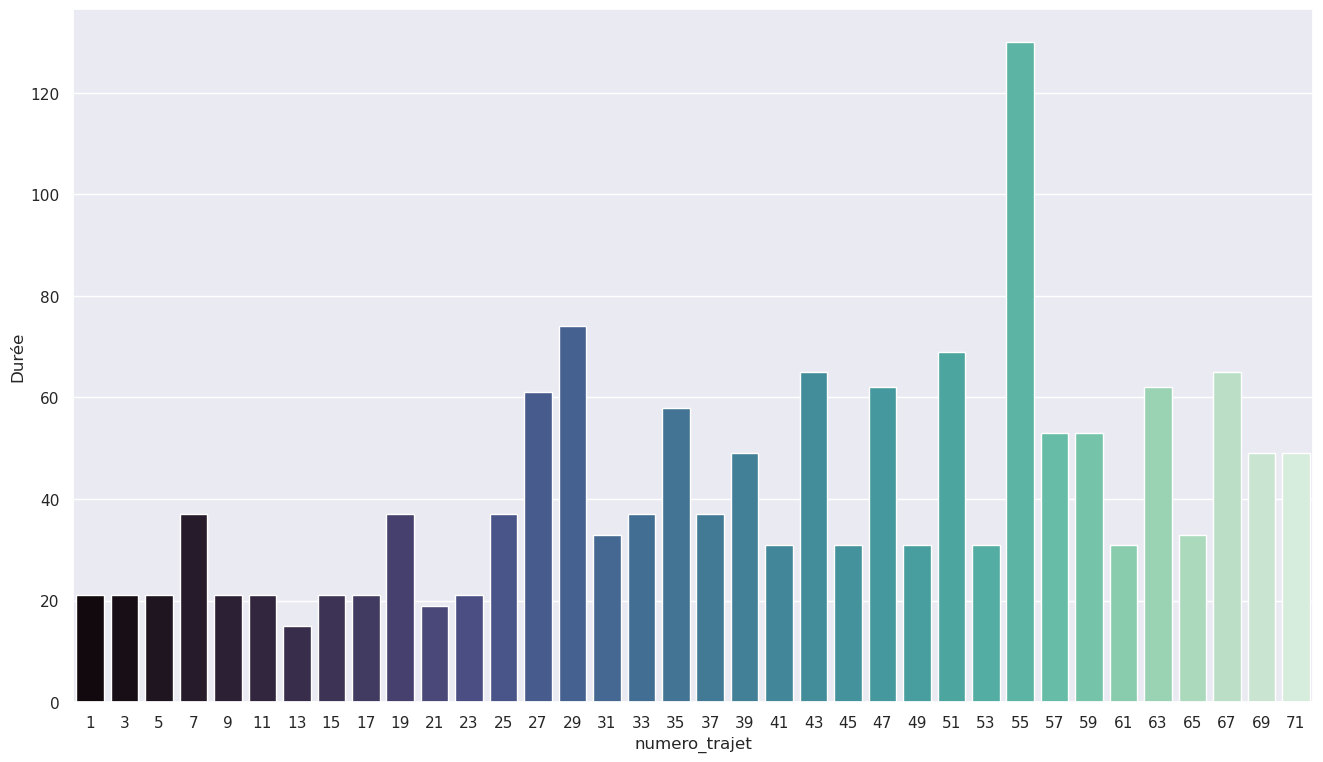

In [26]:
plotTrajet(12)

## 6) Sauvegarde

Sauvegardez votre dataset trajets au format csv dans le dossier data.

In [ ]:
duree.write.format("csv").save("./data/trajets1.csv")